# Solve the 1D Linear Schrödinger equation using Physics Informed Neural Network

In the following, we will solve the dimensionless 1D Schrödinger equation with inhomogeneous Dirichlet boundary conditions using a physics informed neural network.
This boundary values problem can be stated as

$$ i \hbar \partial_t \psi(x, t) = \left(-\frac{\hbar^2}{2m}\partial_x^2 + V(x, t)\right) \psi(x, t) $$
with
$$ \psi(x, t = t_0) \equiv \psi_0(x) \qquad \psi(x=x_l, t) \equiv \psi_L(t) \qquad \psi(x=x_r, t) \equiv \psi_R(t) $$ 
for $t \in [t_0, t_1]$ and $x \in [x_l, x_r]$ and $\psi \in C_2([t_0, t_1] \times [x_l, x_r], \mathbb{C})$.

In the first approach considered here, we approximate $\psi(x, t)$ via a neural network $\psi_{\theta}(x, t)$ that takes two input parameters and outputs two ouput parameters - the real and imaginary part of the wave function. Note that we approximate the wave function in both spatial and temporal dimensions. In order for the NN to satisfy the boundary value problem, the residual of the PDE

$$r_{\theta}(x, t) \equiv \left(i \hbar \partial_t + \frac{\hbar^2}{2m} \partial_x^2 - V(x, t)\right)\psi_{\theta}(x, t) $$
is included in the loss functional. In total, the loss functional then contains three terms: 
 - The mean squared residual
 - The mean squared misfit w.r.t. initial conditions
 - The mean squared misfit w.r.t. boundary conditions

It is minimised over a number of collocation points that are randomly sampled from $[t_0, t_1] \times [x_l, x_r]$.

### Includes

In [33]:
# import libraries
import tensorflow as tf
import numpy as np

# use single precision
rtype = 'float32'
ctype = 'complex64'
tf.keras.backend.set_floatx(rtype)

### Define the test problem

In the first test, we consider a stationary Gaussian wave packet in the center of the domain. 

In [206]:
t0    = tf.constant(0.0)  # initial time
t1    = tf.constant(0.02) # final time
xl    = tf.constant(0.0)  # left domain boundary
xr    = tf.constant(1.0)  # right domain boundary
xc    = tf.constant(0.5, dtype=ctype)       # center of wave packet
alpha = tf.constant(1.0 / 100, dtype=ctype) # width of wave packet
hbar  = tf.constant(1, dtype=ctype) # physical constants
mass  = tf.constant(1, dtype=ctype) # physical constants

# define stationary gaussian wave packet
# complex numbers are treated as vectors of length 2
# this generalises to higher dimensional output vectors

@tf.function
def psi(x, t):
    # cast real input to complex type
    x_ = tf.cast(x, dtype=ctype)
    t_ = tf.cast(t, dtype=ctype)
    j_ = tf.constant(1j, dtype=ctype)

    norm = tf.sqrt(1/(alpha+j_*t_*hbar/mass))
    psi  = norm * tf.exp(-((x_ - xc)**2)/(2*(alpha+j_*t_*hbar/mass)))
    return tf.concat([tf.math.real(psi), tf.math.imag(psi)], axis=1)


@tf.function
def get_density(psi):
    return tf.square(psi[:, 0]) + tf.square(psi[:, 1])

Generate collocation points as well as points of initial and boundary data by random sampling from a uniform distribution. 

In [183]:
n_initial     = 50
n_boundary    = 50
n_collocation = 10000

# set random seed
tf.random.set_seed(0)

# draw initial data at t0 from uniform distribution
t_initial   = tf.ones((n_initial, 1), dtype=rtype) * t0
x_initial   = tf.random.uniform((n_initial, 1), xl, xr, dtype=rtype)
xt_initial  = tf.concat([x_initial, t_initial], axis=1)
psi_initial = psi(x_initial, t_initial)


# draw boundary data from uniform distributions for t and x
t_boundary   = tf.random.uniform((n_boundary,1), t0, t1, dtype=rtype)
# map to left and right boundary via Bernoulli distribution
x_boundary   = xl + (xr - xl) * tf.keras.backend.random_bernoulli((n_boundary,1), 0.5, dtype=rtype)
xt_boundary  = tf.concat([x_boundary, t_boundary], axis=1)
psi_boundary = psi(x_boundary, t_boundary)

# draw collocation points from uniform distribution
t_collocation  = tf.random.uniform((n_collocation,1), t0, t1, dtype=rtype)
x_collocation  = tf.random.uniform((n_collocation,1), xl, xr, dtype=rtype)
xt_collocation = tf.concat([x_collocation, t_collocation], axis=1)

xt_initial.shape, psi_initial.shape, xt_boundary.shape, xt_initial.shape, xt_collocation.shape

(TensorShape([50, 2]),
 TensorShape([50, 2]),
 TensorShape([50, 2]),
 TensorShape([50, 2]),
 TensorShape([10000, 2]))

## Visualise initial and boundary data

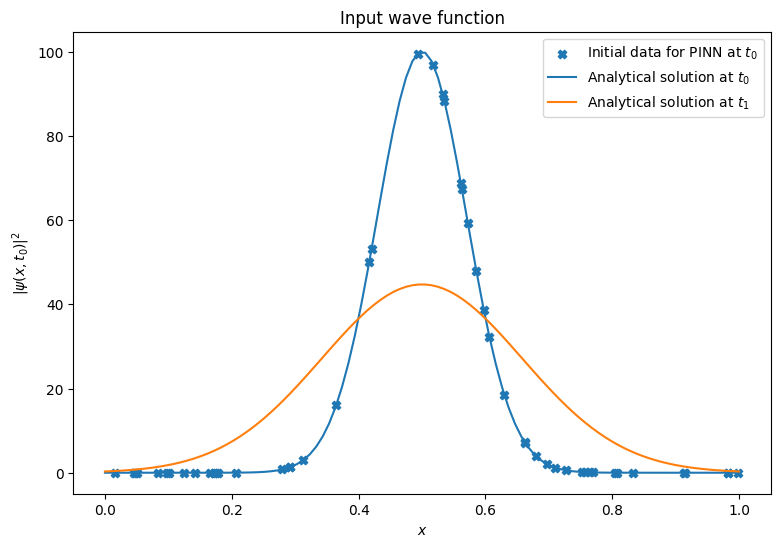

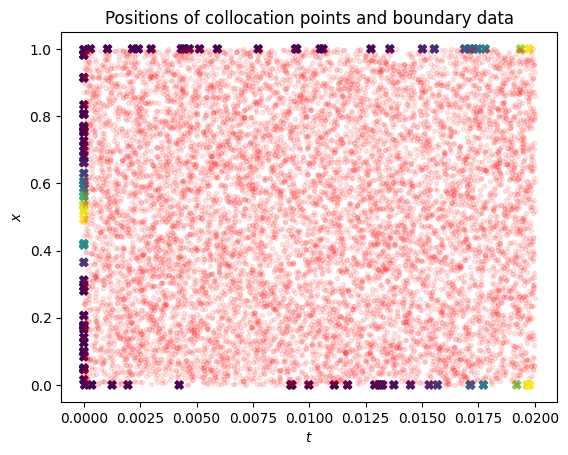

In [197]:
import matplotlib.pyplot as plt

n_linear     = 100
# Make sure that input times and positions are tensors of shape (n, 1) because that is what psi expects
t0_linear    = tf.ones((n_linear, 1)) * t0
t1_linear    = tf.ones((n_linear, 1)) * t1
x_linear     = tf.reshape(tf.linspace(xl, xr, n_linear), (n_linear, 1))
psi_0_linear = psi(x_linear, t0_linear)
psi_1_linear = psi(x_linear, t1_linear)

fig = plt.figure(figsize=(9,6))
plt.title('Input wave function')
plt.scatter(x_initial, get_density(psi_initial),  marker='X', label="Initial data for PINN at $t_0$")
plt.plot(x_linear, get_density(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.plot(x_linear, get_density(psi_1_linear), label=r"Analytical solution at $t_1$")
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Positions of collocation points and boundary data')
plt.scatter(t_initial,     x_initial,     c=get_density(psi_initial),  marker='X')
plt.scatter(t_boundary,    x_boundary,    c=get_density(psi_boundary), marker='X')
plt.scatter(t_collocation, x_collocation, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()


## Create a neural network

Create simple fully connected feedforward model with $8$ hidden layers and $20$ neurons per layer. 

In [198]:
# Lower bounds
lower_bounds = tf.stack([xl, t0], axis= 0)
# Upper bound
upper_bounds = tf.stack([xr, t1], axis= 0)

# Initialise fully-connected neural network
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(2)) # 2D input

    scaling_layer = tf.keras.layers.Lambda(
        lambda x: 2.0*(x - lower_bounds)/(upper_bounds - lower_bounds) - 1.0
    )

    model.add(scaling_layer)

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get("tanh"), kernel_initializer="glorot_normal"))

    model.add(tf.keras.layers.Dense(2)) # 2 outputs for real and imaginary part

    return model

# Check whether model interface works as expected
m = init_model()
m(xt_collocation)

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[-0.14073312, -0.06746697],
       [-0.05511465,  0.08158937],
       [ 0.16333431, -0.01864746],
       ...,
       [ 0.13663577,  0.10236966],
       [-0.09519015,  0.14052235],
       [-0.05911498,  0.0549754 ]], dtype=float32)>


Compute gradients efficiently with gradient tape and return residual for given problem 

In [199]:
#@tf.function
def compute_residual(model, xt):
    with tf.GradientTape(persistent=True) as tape:
        # Separate x and t for GradientTape to watch variables separately
        x, t = xt[:,  0:1], xt[:, 1:2]
        tape.watch(x)
        tape.watch(t)

        # Stick x and t back together for model input
        xt_input = tf.concat([x, t], axis=1)
        psi = model(xt_input)

        # Split into real and imaginary parts
        re = psi[:, 0]
        im = psi[:, 1]

        # Compute gradient in tape environment in order to compute second derivatives
        re_x = tape.gradient(psi, x)
        im_x = tape.gradient(psi, x)

    re_t  = tape.gradient(re, t)
    im_t  = tape.gradient(im, t)
    re_xx = tape.gradient(re_x, x)
    im_xx = tape.gradient(im_x, x)

    del tape

    # Residual

    r_re = - im_t - 0.5 * re_xx
    r_im =   re_t - 0.5 * im_xx

    return tf.concat([r_re, r_im], axis=1)

# Check whether compute_residual works as expected
compute_residual(init_model(), xt_collocation)

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[-11.8326025, -14.15216  ],
       [ -9.237933 ,  -9.045186 ],
       [-12.071962 , -11.443411 ],
       ...,
       [-10.552437 , -13.939282 ],
       [ -6.138145 ,  -1.1913747],
       [-10.326594 , -11.03827  ]], dtype=float32)>

Add residual and MSE for initial and boundary data

In [200]:
#@tf.function
def compute_loss(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary):
    loss  = tf.reduce_mean(tf.square(compute_residual(model, xt_collocation))) # Enforce PDE dynamics
    loss += tf.reduce_mean(tf.square(model(xt_initial)  - psi_initial))    # Enforce initial conditions
    loss += tf.reduce_mean(tf.square(model(xt_boundary) - psi_boundary))   # Enforce boundary conditions
    return loss

Compute loss and run backpropagation

In [201]:
#@tf.function
def compute_gradient(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary):

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary)

    g = tape.gradient(loss, model.trainable_variables)

    return loss, g


Choose optimiser for model

In [202]:
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Call model with collocation points C_r, points for initial and boundary conditions X_r and values for initial and boundaries conditions X_r, compute loss, run backpropagation and run optimiser with gradients.

In [203]:
xt_initial.shape, psi_initial.shape

(TensorShape([50, 2]), TensorShape([50, 2]))

In [204]:
from time import time

#@tf.function
def train_step():
    loss, grad_theta = compute_gradient(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary)

    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

N = 5000
hist = []

t0 = time()

for i in range(N+1):
    loss = train_step()
    hist.append(loss.numpy())

    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


It 00000: loss = 7.97246155e+02
It 00050: loss = 7.22604179e+00
It 00100: loss = 7.02611637e+00
It 00150: loss = 6.99898672e+00
It 00200: loss = 6.97254753e+00


KeyboardInterrupt: 

Text(0.5, 0.92, 'Solution of Burgers equation')

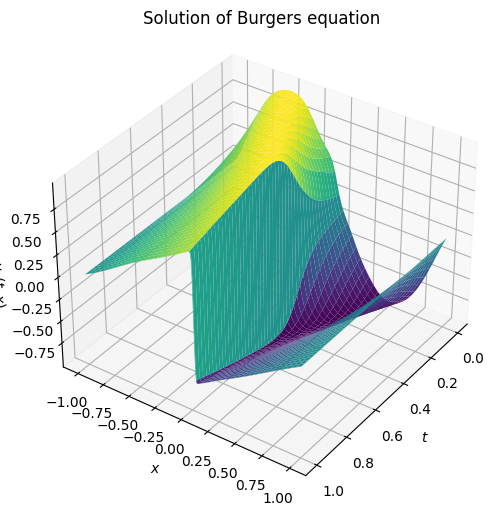

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')

ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation')
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

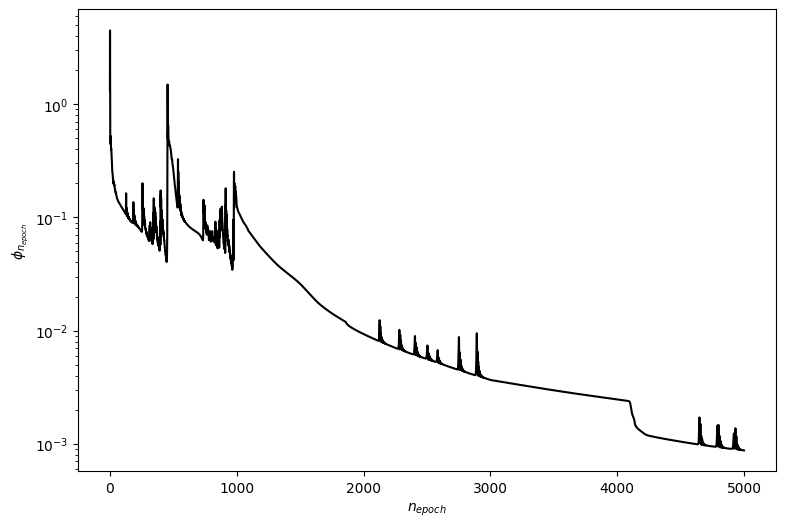

In [33]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [ ]:
def u(t, x):
    u = neural_net(tf.concat([t, x], 1), weights, bias)
    return u

def f(t, x):
    u = u(t, x)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    t = u_t + u*u_x - (0.01/tf.pi) * u_xx
    return f

The shared parameters between the neural networks u(t,x) and f(t,x)

can be learned by minimizing the mean squared error loss
$$MSE=MSEu+MSEf$$

where
$$MSEu=1Nu∑i=1Nu|u(tiu,xiu)−ui|2,$$

and
$$MSEf=1Nf∑i=1Nf|f(tif,xif)|2.$$



Here, ${tiu,xiu,ui}Nui=1$
denote the initial and boundary training data on u(t,x) and {tif,xif}Nfi=1 specify the collocations points for $f(t,x)$. The loss MSEu corresponds to the initial and boundary data while MSEf enforces the structure imposed by the Burgers’ equation at a finite set of collocation points.